In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
df = pd.read_csv('/content/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [ ]:
df.tail()

,user_id,timestamp,group,landing_page,converted
294475,734608,45:03.4,control,old_page,0
294476,697314,20:29.0,control,old_page,0
294477,715931,40:24.5,treatment,new_page,0
294478,759899,20:29.0,treatment,new_page,0
294479,643532,40:24.5,treatment,new_page,0


In [3]:
df_countries = pd.read_csv('/content/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [ ]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [4]:
data = pd.merge(df_countries, df, on='user_id', how='right')
data.head()

,user_id,country,timestamp,group,landing_page,converted
0,851104,US,11:48.6,control,old_page,0
1,804228,US,01:45.2,control,old_page,0
2,661590,US,55:06.2,treatment,new_page,0
3,853541,US,28:03.1,treatment,new_page,0
4,864975,US,52:26.2,control,old_page,1


In [ ]:
data.tail()

,user_id,country,timestamp,group,landing_page,converted
294477,697314,US,20:29.0,control,old_page,0
294478,715931,UK,40:24.5,treatment,new_page,0
294479,759899,US,20:29.0,treatment,new_page,0
294480,759899,US,20:29.0,treatment,new_page,0
294481,643532,US,40:24.5,treatment,new_page,0


In [ ]:
data.nunique()

,0
user_id,290585
country,3
timestamp,35993
group,2
landing_page,2
converted,2


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,294482.0,787973.348225,91210.636700,630000.0,709032.25,787931.5,866910.75,945999.0
converted,294482.0,0.119658,0.324561,0.0,0.00,0.0,0.00,1.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294482 entries, 0 to 294481
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294482 non-null  int64 
 1   country       294482 non-null  object
 2   timestamp     294482 non-null  object
 3   group         294482 non-null  object
 4   landing_page  294482 non-null  object
 5   converted     294482 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 13.5+ MB


In [ ]:
data.isnull().sum()

,0
user_id,0
country,0
timestamp,0
group,0
landing_page,0
converted,0


In [ ]:
data.duplicated().sum()

2

In [ ]:
data[data.duplicated()]

,user_id,country,timestamp,group,landing_page,converted
250002,759899,US,07:36.1,treatment,new_page,0
294480,759899,US,20:29.0,treatment,new_page,0


I am not removing the duplicates, despite showing it as duplicate, timestamp is different. So, not removing duplicates.

# Objective I:
To determine whether the new page performs better than the old page.

* Control Group: Users who saw the old page (landing_page = 'old_page').
* Experiment Group: Users who saw the new page (landing_page = 'new_page').

In [5]:
data.groupby(by = 'landing_page')['converted'].value_counts().unstack()

converted,0,1
landing_page,,
new_page,129745,17498
old_page,129500,17739


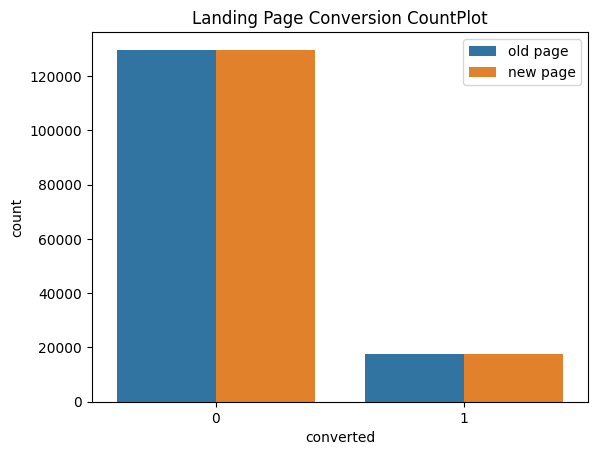

In [6]:
sns.countplot(data, hue = 'landing_page', x = 'converted')
plt.legend(labels = ['old page', 'new page'])
plt.title('Landing Page Conversion CountPlot')
plt.show()

#Hypothesis

* Null hypothesis(Ho): There is no significant difference between a conversion rate in old page and new page.
* Alternative hypotheis(Ha): There is a significant difference between conversion rate in old page and new page.

Since it's a discrete metric, and have a large sample size, I am selecting two sample proportion test. Discrete have only two values 0 and 1. The choice of one-tailed test or two-tailed test depends on the original claim.

#Parameters of Model for Power Analysis


*  beta: Probability of Type II Error
*  (1- beta): Power of the tets
*  alpha: Probability of Type I Error
*  delta: Minimum detectable effect


In [49]:
alpha = 0.05

delta = 0.15


#Two sample Proportion test

In [50]:
X_con = data.groupby(by = 'landing_page')['converted'].sum().loc['old_page']
X_con

17739

In [51]:
X_exp = data.groupby(by = 'landing_page')['converted'].sum().loc['new_page']
X_exp

17498

In [52]:
con = df[df['landing_page'] == 'old_page'].shape[0]
con

147239

In [53]:
exp = df[df['landing_page'] == 'new_page'].shape[0]
exp

147241

In [54]:
p_con_hat = X_con/con
p_exp_hat = X_exp/exp
print("Click probability in Control group", p_con_hat)
print("Click probability in Control group", p_exp_hat)

#estimation of pooled click probability
p_pooled_hat = (X_con + X_exp) / (con + exp)

Click probability in Control group 0.12047759085568362
Click probability in Control group 0.118839182021312


In [55]:
pooled_variance= p_pooled_hat * (1 - p_pooled_hat) * (1/con + 1/exp)
print("pooled_variance is: ", pooled_variance)

pooled_variance is:  1.430864612415805e-06


#Calculating Standard Error and Test Statistics

---



In [56]:
SE = np.sqrt(pooled_variance)

print('Standard Error is: ', SE)

Standard Error is:  0.0011961875322940819


In [57]:
test_stat = (p_con_hat - p_exp_hat)/SE
print('Test Statistics for 2-sample Z-test is:', test_stat)

Test Statistics for 2-sample Z-test is: 1.3696922849792916


In [58]:
z_crit = norm.ppf(1- alpha/ 2)
print('Z-critical value from Standard Normal is:', z_crit)

Z-critical value from Standard Normal is: 1.959963984540054


#Calculating p-valuesof the z-test
* A low p-value (less than the significance level, α < 0.05) indicates that the observed result provides strong evidence against null hypothesis, so we reject null hypothesis.
* A high p-value (more than the significance level, α > 0.05) indicates that the observed result provides weak evidence against null hypothesis, so we fail to reject null hypothesis.

In [59]:
p_value = 2* norm.sf(abs(test_stat)) #two_tailed
p_value

0.170782978025938

In [68]:
def is_statistical_significance(p_value, alpha):
  print(f"P-value of A/B test: {round(p_value, 3)}")

  if p_value < alpha:
    print("There is statistical significance indicating that the observed difference between groups are unlikely to have occurred by chance alone.")
  else:
    print("There is no statistical significance, indicating that the suggesting the difference between groups have occurred by chance alone.")


In [61]:
is_statistical_significance(p_value, alpha)

P-value of the 2-sample z-test: 0.171
There is no statistical significance, indicating that the suggesting the difference between groups have occurred by chance alone.


In [62]:
CI = [((p_exp_hat - p_con_hat) - SE * z_crit), #Lower Bound of our CI
      ((p_exp_hat - p_con_hat) + SE * z_crit)] #Upper Bound of our CI

print("Confidence Interval of the 2 sample z-test is:", CI)

Confidence Interval of the 2 sample z-test is: [-0.003982893316423864, 0.0007060756476806218]


Even though confidence interval is narrow, CI contains 0, it means that there is a high probability that the true difference in landing_pages is not statitstically significant and fail to reject null hypothesis.





#Chi-squared

to conclude whether the two variables( conversion and country ) are related to each other not.

In [63]:
from scipy.stats import chi2_contingency

In [64]:
tab = pd.crosstab(data['converted'], data['country']).T
tab

converted,0,1
country,,
CA,12992,1703
UK,64566,8853
US,181687,24681


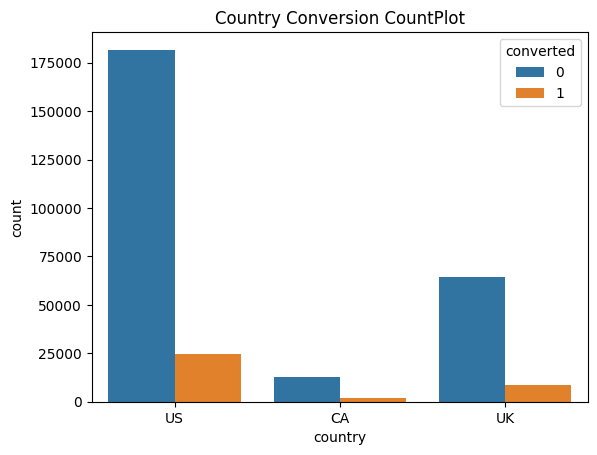

In [72]:
sns.countplot(data, hue = 'converted', x = 'country')
plt.title('Country Conversion CountPlot')
plt.show()

#Hypothesis

* Null hypothesis(Ho): There is no significant difference between a conversion rate in any countries(US, UK, CA)
* Alternative hypotheis(Ha): There is a significant difference between conversion rate in countries

In [67]:
stat, p, dof, expected = chi2_contingency(tab)

print("p value is " + str(p))
print("degree of freedom is " + str(dof))
print("F stat is " + str(stat))

p value is 0.2748533115574644
degree of freedom is 2
F stat is 2.5830354722978903


In [69]:
is_statistical_significance(p, alpha)

P-value of A/B test: 0.275
There is no statistical significance, indicating that the suggesting the difference between groups have occurred by chance alone.


p-value (0.275) is above the threshold, so we fail to reject the null hypothesis that country affects the conversion rate.